In [1]:
from zs6d import ZS6D
import os
import json


# Loading the config file:
with open(os.path.join("./zs6d_configs/bop_eval_configs/cfg_ycbv_inference_bop.json"), "r") as f:
    config = json.load(f)

# TODO: Fix Groundtruths -> 642 instead of 341 templates

# Instantiating the pose estimator:
# This involves handing over the path to the templates_gt file and the corresponding object norm_factors.
pose_estimator = ZS6D(config['templates_gt_path'], config['norm_factor_path'])

device=cuda


Using cache found in C:\Users\Shype/.cache\torch\hub\facebookresearch_dino_main
100%|██████████| 21/21 [01:31<00:00,  4.34s/it]


Matches Template: 16
R_est: [[ 0.90892071 -0.00682423 -0.41691315]
 [-0.16837465  0.90871516 -0.38195122]
 [ 0.38146183  0.41736098  0.824801  ]]
t_est: [-42.04526933 -96.81424003 917.69423235]
R_gt: [[ 0.93734285  0.02582689 -0.34745156]
 [-0.159908    0.9179002  -0.36316394]
 [ 0.30954673  0.39596943  0.86451608]]
t_gt: [-29.13229126 -90.5821677  899.63462545]
Init (3.616291547114493, 1.0)


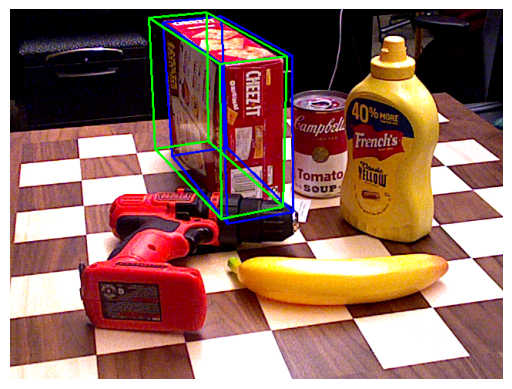

Matches Template: 440
R_est: [[-0.99745191 -0.06566452 -0.02789008]
 [ 0.0022378   0.36194496 -0.93219678]
 [ 0.07130693 -0.92988387 -0.36087575]]
t_est: [ 73.64375803 -57.52422019 925.86520583]
R_gt: [[-0.98956866 -0.13424731 -0.05226682]
 [-0.00202918  0.37575563 -0.92671641]
 [ 0.14404914 -0.91694325 -0.37210858]]
t_gt: [ 76.66447771 -52.23949357 867.67424663]
Init (3.12143346781739, 1.0)


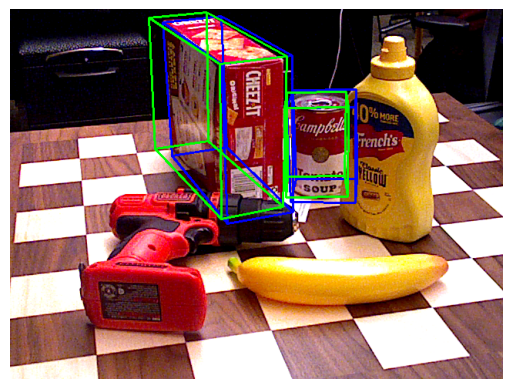

Matches Template: 400
R_est: [[-9.95884938e-01 -9.06236365e-02 -7.38973992e-04]
 [-3.99171897e-02  4.45950920e-01 -8.94166872e-01]
 [ 8.13621997e-02 -8.90457822e-01 -4.47733246e-01]]
t_est: [130.53863238 -58.545718   799.08471982]
R_gt: [[-0.93124982 -0.36312329 -0.03024262]
 [-0.11868583  0.3807506  -0.91702906]
 [ 0.34450928 -0.85039392 -0.397672  ]]
t_gt: [128.42555427 -52.24211384 769.32512681]
Init (12.587026560606, 1.0)


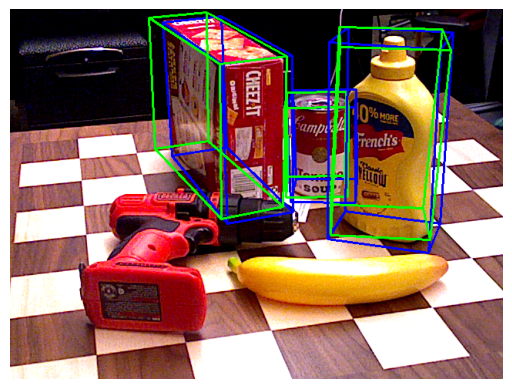

Matches Template: 519
R_est: [[-0.22423659 -0.97096289 -0.08336077]
 [-0.40922111  0.17144718 -0.89618299]
 [ 0.88445239 -0.16684403 -0.43578324]]
t_est: [ 73.65157116  63.32111034 721.11352921]
R_gt: [[-0.31135289 -0.94956499 -0.03721784]
 [-0.42064233  0.17283123 -0.89061137]
 [ 0.85212635 -0.26163881 -0.45323894]]
t_gt: [ 76.66015458  58.06398744 709.85649524]
Init (4.1140671030231575, 1.0)


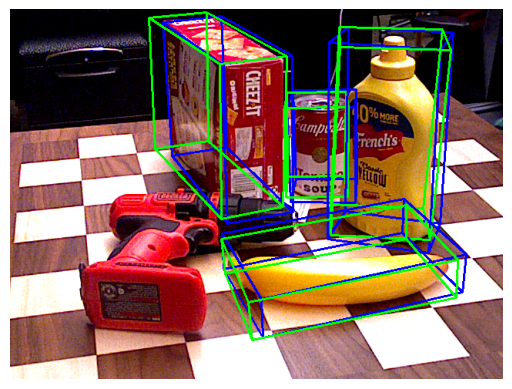

Matches Template: 146
R_est: [[-0.93052229  0.36429588 -0.03764017]
 [-0.10669963 -0.36798181 -0.92369074]
 [-0.35034763 -0.85549863  0.38128551]]
t_est: [-74.88129804  33.15693517 819.66964114]
R_gt: [[-0.97699658  0.19700101  0.08166193]
 [-0.00126849 -0.38829145  0.92153575]
 [ 0.21325129  0.90023346  0.37960952]]
t_gt: [-53.09448788  49.67578364 718.42612262]
Init (93.87255297277096, 0.0)


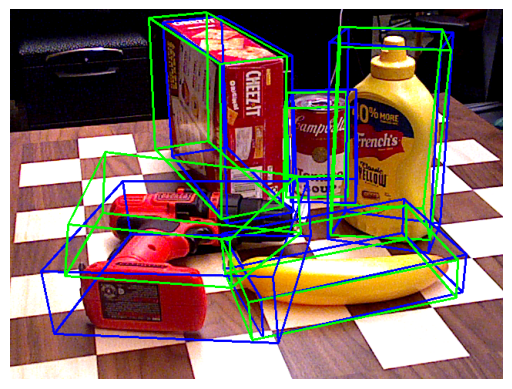

In [3]:
import cv2
from PIL import Image
import pose_utils.img_utils as img_utils
import pose_utils.vis_utils as vis_utils
import pose_utils.eval_utils as eval_utils
import numpy as np
import time
import matplotlib.pyplot as plt
import copy

# Loading a ground truth file to access segmentation masks to test zs6d:
with open(os.path.join(config['gt_path']), 'r') as f:
    data_gt = json.load(f)

img_id = '000050_1778'
scene = img_id.split('_')[0]
img_nr = "{img:06}".format(img=int(img_id.split('_')[1]))  

# Open Ground Truth for BB
path = f"./test/ycbv/{scene}/scene_gt.json"
with open(path, 'r') as f:
        bb_gt = json.load(f)

rgb_img_gt = np.array(Image.open(f"test/ycbv/{img_id.split('_')[0]}/rgb/{img_nr}.png"))
rgb_img_gt_ref = np.array(Image.open(f"test/ycbv/{img_id.split('_')[0]}/rgb/{img_nr}.png"))

for i in range(len(data_gt[img_id])):
    obj_number = i  # Gets the i-th object in the image
    obj_id = data_gt[img_id][obj_number]['obj_id']      # Gets the corresponding object_id for the current object
    cam_K = np.array(data_gt[img_id][obj_number]['cam_K']).reshape((3,3))
    bbox = data_gt[img_id][obj_number]['bbox_visib']    # Gets the Bounding Box Parameters for the current object
    img_path = f"test/ycbv/{scene}/rgb/{img_nr}.png"  #"test/000048/rgb/000001.png"
    #os.path.join(config['dataset_path'], data_gt[img_id][obj_number]['img_name'].split("./")[-1])
    img = Image.open(img_path)  
    img_temp = copy.deepcopy(img)
    
    mask = data_gt[img_id][obj_number]['mask_sam']
    mask = img_utils.rle_to_mask(mask)
    mask = mask.astype(np.uint8)
    
    try:
        # To estimate the objects Rotation R and translation t the input image, the object_id, a segmentation mask and camera matrix are necessary
        R_est, t_est = pose_estimator.get_pose(img_temp, str(obj_id), mask, cam_K, num_comp=361, bbox=None)
    except Exception as e:
        print("Error")
        continue
    
    print(f"R_est: {R_est}")
    print(f"t_est: {t_est}")
    #print(f"R_ref: {R_ref}")
    #print(f"t_ref: {t_ref}")
    obj_gt_bb = bb_gt[img_id.split('_')[-1]][obj_number]
    print(f"R_gt: {np.array(obj_gt_bb['cam_R_m2c']).reshape((3,3))}")
    print(f"t_gt: {np.array(obj_gt_bb['cam_t_m2c'])}")
    
    # Add Ground Truth BB
    rgb_img_gt = vis_utils.draw_3D_bbox_on_image(np.array(rgb_img_gt), np.array(obj_gt_bb['cam_R_m2c']).reshape((3,3)), np.array(obj_gt_bb['cam_t_m2c']), cam_K, data_gt[img_id][obj_number]['model_info'], factor=1, colEst=(0,0,255))
    
    rgb_img_gt_ref = vis_utils.draw_3D_bbox_on_image(np.array(rgb_img_gt_ref), np.array(obj_gt_bb['cam_R_m2c']).reshape((3,3)), np.array(obj_gt_bb['cam_t_m2c']), cam_K, data_gt[img_id][obj_number]['model_info'], factor=1, colEst=(0,0,255))
    
    #plt.axis('off')
    #plt.imshow(rgb_img_gt)
    #plt.show()
    
    # Mark Very Wrong guesses in RED
    #colEst1 = (255, 0, 0) if eval_utils.calculate_score(R_est, np.array(obj_gt_bb['cam_R_m2c']).reshape((3,3)), obj_id)[1] == 0 else (0, 255, 0)
    #colEst2 = (255, 0, 0) if eval_utils.calculate_score(R_ref, np.array(obj_gt_bb['cam_R_m2c']).reshape((3,3)), obj_id)[1] == 0 else (0, 255, 0)
    
    colEst1 = (0,255,0)
    colEst2 = (0,255,0)
 
    print("Init",eval_utils.calculate_score(R_est, np.array(obj_gt_bb['cam_R_m2c']).reshape((3,3)), obj_id))
    #print("Ref",eval_utils.calculate_score(R_ref, np.array(obj_gt_bb['cam_R_m2c']).reshape((3,3)), obj_id))
    
    # Add Initial BB
    rgb_img_gt = vis_utils.draw_3D_bbox_on_image(rgb_img_gt, R_est, t_est, cam_K, data_gt[img_id][obj_number]['model_info'], factor=1, colEst=colEst1)
    
    plt.axis('off')
    plt.imshow(rgb_img_gt)
    plt.show()
    
    # Add Refined BB
    #rgb_img_gt_ref = vis_utils.draw_3D_bbox_on_image(rgb_img_gt_ref, R_ref, t_ref, cam_K, data_gt[img_id][obj_number]['model_info'], factor=1, colEst=colEst2)

    #plt.axis('off')
    #plt.imshow(rgb_img_gt_ref)
    #plt.show()
